# Using TextBlob and Vader as Out of the Box Analysers

This notebook uses two 'Out of the Box' or Rules-based sentiment analysers, TextBlob and Vader to determine the sentiment of the training set reviews. The analyser is not learning anything, it is simply treating each review separately and comparing it to a set of rules. The data can be fed raw into the analyser (although cleaning can be used first) and does not need the extensive cleaning of machine learning models, which make them very easy and quick to use.

* Section 1 - import libraries and dataset
* Section 2 - Pre-processing

* Section 2 - analyser performance against sample phrases  
* Section 3 - TextBlob and VADER 
* Section 4 - Comparison of analyser scores with user scores
* Section 5 - VADER scores compared to review length
* Section 6 - Rerunning results with cleaned review text
* Section 7 - Summary

*Note: Rating refers to the user rating and score is the binary score allocated - with 1 referring to the majority class of positive reviews and -1 relating to the minority class of negative reviews.*

Data needed to run notebook:

* sampled_data.csv
* cleanedsampletext.csv

# Section 1: Import libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv('sampled_data.csv',index_col = 0)

In [31]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine,Score
0,The Spur,Food,Arundel,Pub/Bar,14,Very disappointing,Three of us ate on a quiet night. First of all...,2,4.0,2.0,British,1
1,Inglenook,Accommodation,Bognor,Hotel,10,Amazing place!!!,We had a lovely stay at the Inklenook ..room w...,5,1.0,1.0,0,0


In [32]:
# Function to select columns of interest, join title and review, drop unwanted columns and reset index
def proc(df):
    df = df[["Town","Category","Title","Review","Score"]]
    df["all_text"] = df["Title"] +" "+ df["Review"]
    df.drop(columns = ["Title","Review"],axis = 1, inplace = True)
    df.columns = ["Town","Category","Score","all_text"]
    return df

In [33]:
df = proc(df)

In [34]:
df.head()

,Town,Category,Score,all_text
0,Arundel,Food,1,Very disappointing Three of us ate on a quiet ...
1,Bognor,Accommodation,0,Amazing place!!! We had a lovely stay at the ...
2,Bognor,Food,0,"Seaside Cafe Great cafe, located near to shine..."
3,Arundel,Food,0,Delicious Tasty Roast Had the most delicious t...
4,Littlehampton,Food,1,"High priced low volume Beautiful setting, grea..."


# Section 2: Preprocessing

In [36]:
# Put bad reviews as -1 and good reviews as 1
df.Score.replace(1, -1, inplace = True)
df.Score.replace(0, 1, inplace = True)

In [37]:
# Compare numbers of positive and negative reviews
df.Score.value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

# Section 3: Testing TextBlob and Vader Against Sample Phrases

In [38]:
# Set up an analyser object for Vader
sia = SentimentIntensityAnalyzer()

In [39]:
# Results function
def pol(text):
    pol1 = TextBlob(text).sentiment.polarity
    pol2 = sia.polarity_scores(text)['compound']
    return pol1, pol2, 

## Capitalisation

In [40]:
# Capitalisation of a word
t1 = "This is the worst restaurant I have ever eaten in"
t2 = "This is the WORST restaurant I have ever eaten in"

In [41]:
sent_1 = pol(t1)
sent_2 = pol(t2)
data1 = pd.DataFrame([sent_1,sent_2],index = ["S1","S2"],columns = ["TextBlob","Vader"])
data1.T

,S1,S2
TextBlob,-1.0000,-1.0000
Vader,-0.6249,-0.7034


* Both analysers are negative but only Vader picks up the intensity of capitalisation

## Word Strength

In [42]:
# Word Strength
t3 = "The food is good"
t4 = "The food is great"
t5 = "The food is incredible"
t6 = "The food is awesome"

In [43]:
sent_3 = pol(t3)
sent_4 = pol(t4)
sent_5 = pol(t5)
sent_6 = pol(t6)
data2 = pd.DataFrame([sent_3,sent_4,sent_5,sent_6],index = ["S3","S4","S5","S6"],columns = ["TextBlob","Vader"])
data2.T

,S3,S4,S5,S6
TextBlob,0.7000,0.8000,0.9,1.0000
Vader,0.4404,0.6249,0.0,0.6249


* TextBlob picks up the increasing intensity of words more effectively than Vader 

## Promotor Words

In [44]:
# Promotor words - modulate intensity
t7 = "The food is good"
t8 = "The food is very good"
t9 = "The food is very very good"

In [45]:
sent_7 = pol(t7)
sent_8 = pol(t8)
sent_9 = pol(t9)
data3 = pd.DataFrame([sent_7,sent_8,sent_9],index = ["S7","S8","S9"],columns = ["TextBlob","Vader"])
data3.T

,S7,S8,S9
TextBlob,0.7000,0.9100,0.9100
Vader,0.4404,0.4927,0.5379


* TextBlob picks up increased instensity from the use of the word 'very'
* Vader picks up the increased intensity from repeated words also

## Double Negation

In [46]:
# Double Negation
t10 = "This is not the worst place in the town, not by any means"

In [47]:
sent_10 = pol(t10)
data4 = pd.DataFrame([sent_10],index = ["S10"],columns = ["TextBlob","Vader"])
data4.T

,S10
TextBlob,-1.0000
Vader,0.5096


* Vader picks up that the review is positive and not negative

## Adjectives

In [48]:
# Adjectives
t11 = "The restaurant is worth visiting"
t12 = "The restaurant is hardly worth visiting"

In [49]:
sent_11 = pol(t11)
sent_12 = pol(t12)
data5 = pd.DataFrame([sent_11,sent_12],index = ["S11","S12"],columns = ["TextBlob","Vader"])
data5.T

,S11,S12
TextBlob,0.3000,0.3000
Vader,0.2263,0.1548


* Vader adjusts the score downwards for the word 'hardly'.

## Punctuation

In [50]:
# Punctuation
t13 = "The food is great"
t14 = "The food is great!"
t15 = "The food is great!!"

In [51]:
sent_13 = pol(t13)
sent_14 = pol(t14)
sent_15 = pol(t15)
data6 = pd.DataFrame([sent_13,sent_14,sent_15],index = ["S13","S14","S15"],columns = ["TextBlob","Vader"])
data6.T

,S13,S14,S15
TextBlob,0.8000,1.0000,1.0000
Vader,0.6249,0.6588,0.6892


* VADER picks up the second exclamation mark.

## Intent

In [52]:
# Intent (sarcasm)
t16 = "Is this the best restaurant in town??"

In [53]:
sent_16 = pol(t16)
data7 = pd.DataFrame([sent_16],index = ["S16"],columns = ["TextBlob","Vader"])
data7.T

,S16
TextBlob,1.0000
Vader,0.6767


* Both analysers return positive to a negative sentiment but Vader does have a lower score

## Contrast

In [54]:
# Mixed sentences - contrast
t17 = "The view is amazing but the food is awful"
t18 = "I loved this place, however it could do with a refurbishment"

In [55]:
sent_17 = pol(t17)
sent_18 = pol(t18)
data8 = pd.DataFrame([sent_17,sent_18],index = ["S17","S18"],columns = ["TextBlob","Vader"])
data8.T

,S17,S18
TextBlob,-0.2000,0.7000
Vader,-0.3818,0.5994


* Both analysers swap from negative to positive between the two sentences.

## Context - ambiguous adjectives and one word, many meanings

In [56]:
# Context - ambiguous adjectives - convey perspective
t19 = "The food is pretty good"
t20 = "The food is pretty bad"

# One word with many meanings (low can be seen as negative but in context of prices it isnt)
t21 = "The prices are high"
t22 = "The prices are low"

In [57]:
sent_19 = pol(t19)
sent_20 = pol(t20)
sent_21 = pol(t21)
sent_22 = pol(t22)
data9 = pd.DataFrame([sent_19,sent_20,sent_21,sent_22],index = ["S19","S20","S21","S22"],columns = ["TextBlob","Vader"])
data9.T

,S19,S20,S21,S22
TextBlob,0.4750,-0.2250,0.16,0.0000
Vader,0.7269,-0.0772,0.00,-0.2732


* Both analysers deal with the first two sentences 

## Emojis

In [58]:
t23 = "Love this place"
t24 = "Love this place :)"
sent_23 = pol(t23)
sent_24 = pol(t24)

In [59]:
data10 = pd.DataFrame([sent_23,sent_24],index = ["S23","S24"],columns = ["TextBlob","Vader"])
data10.T

,S23,S24
TextBlob,0.5000,0.500
Vader,0.6369,0.802


# Section 4: Passing All Reviews Through TextBlob and Vader

## TextBlob

In [62]:
# Run TextBlob against each review in the dataframe
df["Polarity"] = df["all_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["Subjectivity"] = df["all_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [65]:
# Check basic descriptive statistics
df.describe()

,Score,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp
count,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000
mean,0.000000,0.161373,0.558723,0.065479,0.745256,0.189264,0.386939
std,1.000192,0.273605,0.121380,0.071509,0.110096,0.137371,0.745357
min,-1.000000,-1.000000,0.000000,0.000000,0.339000,0.000000,-0.996800
25%,-1.000000,-0.033333,0.477083,0.000000,0.680000,0.077000,-0.386150
50%,0.000000,0.169079,0.555556,0.046000,0.760000,0.158000,0.872000
75%,1.000000,0.375000,0.637326,0.104000,0.824000,0.278000,0.966975
max,1.000000,1.000000,1.000000,0.472000,1.000000,0.661000,0.999600


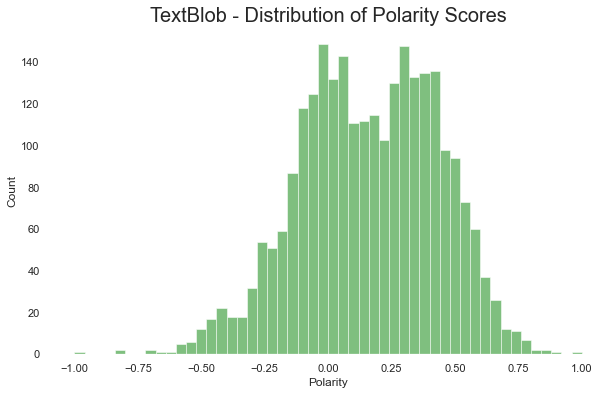

In [66]:
# Look at how the Polarity scores are distributed - TextBlob
num_bins = 50

fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df.Polarity, num_bins, facecolor='green', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('TextBlob - Distribution of Polarity Scores',size = 20)
plt.show();

In [76]:
# How many reviews have positive, neutral and negative sentiment according to TextBlob?
print(df[df["Polarity"] > 0].shape[0])
print(df[(df["Polarity"] == 0) & (df["Polarity"]<0.01)].shape[0])
print(df[df["Polarity"] <0].shape[0])

1817
5
780


Most are rated positive, there are very few neutral as we would expect as the sample data set had reviews rated '3' stripped out, leaving the most highly rated and lowest rated reviews in the dataset. The distribution appears bimodal.

In [77]:
# Get skew - small negative skew
df.Polarity.skew()

-0.22690765121306322

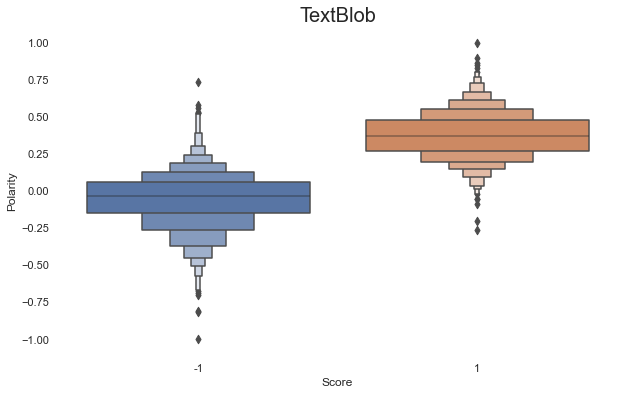

In [82]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='Polarity', data=df)
plt.title("TextBlob",fontsize = 20)
plt.show();

## VADER

In [ ]:
# Run VADER against each review in the dataframe
df["VNeg"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['neg'])
df["VNeu"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['neu'])
df["VPos"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['pos'])
df["VComp"] = df["all_text"].apply(lambda x: sia.polarity_scores(x)['compound'])

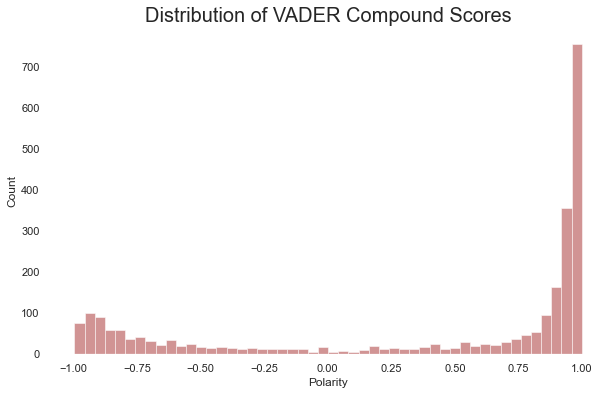

In [78]:
# Plot Vader Compound Scores
num_bins = 50
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(df.VComp, num_bins, facecolor='brown', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of VADER Compound Scores', fontsize = 20)
plt.show();

In [79]:
# How many reviews have sentiment above and below 0.05 threshold suggested in the documentation
print(df[df["VComp"] >= 0.05].shape[0])
print(df[(df["VComp"] <0.05) & (df["VComp"] > -0.05)].shape[0])
print(df[df["VComp"] <= -0.05].shape[0])

1811
27
764


Vader has a few more neutrals, probably because the threshold scores are a bit different as per the documentation. The distribution of polarities is very different however.

In [80]:
# Get skew of VComp distribution
df.VComp.skew()

-0.830825005700086

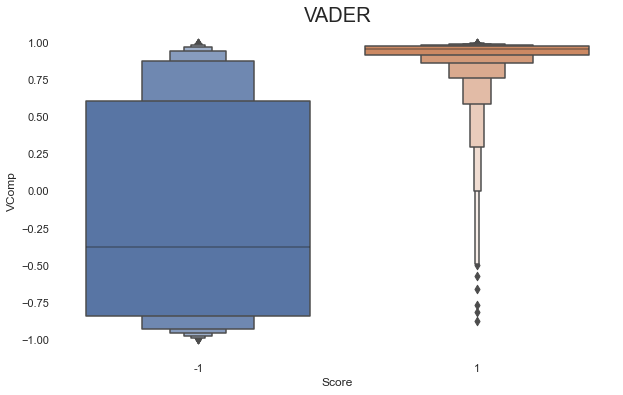

In [84]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxenplot(x='Score', y='VComp', data=df)
plt.title("VADER",fontsize = 20)
plt.show();

* TextBlob scores are slightly negatively skewed with bimodal distribution
* VADER's distribution is negatively skewed with a unimodal distribution
* VADER scores most reviews as strongly positive and there are outliers.  
* The boxplot for VADER shows greater variation in the compound polarity for negative reviews compared to positive. 

# Section 4: Comparison of Analyser Scores with User Rating

## TextBlob

Uses a weighted average score over all the words in a sentence

In [86]:
# Check for any polaritiy scores that are zero or neutral sentiment
df[df["Polarity"] == 0]

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp
213,Arundel,Food,-1,A Miss Evening dinner disaster.\nLost our rese...,0.0,0.7,0.341,0.659,0.000,-0.9097
306,Arundel,Food,-1,I think you have to announce your arrival ... ...,0.0,0.4,0.113,0.835,0.051,-0.5046
432,Bognor,Food,-1,Overcharged on the bill £29. We were a party o...,0.0,0.5,0.061,0.796,0.143,0.4767
1746,Bognor,Food,1,Aprils Hen do Meal TONY what a legend!!!!! Ove...,0.0,0.6,0.000,0.886,0.114,0.5951
2134,Bognor,Food,1,A local gem Went here for lunch with my mum mi...,0.0,0.0,0.000,0.906,0.094,0.4019


In [87]:
# Set polarities greater than zero 1 and polarities less than zero to -1 
# Assume for ease that polarity >0 is positive and <=0 is negative, so any neutral polarities are ignored

conditions = [(df["Polarity"]>0),df["Polarity"]<=0]
choices = [1,-1]
df["TB_score"] = np.select(conditions,choices,default = 'null')
df["TB_score"] = df["TB_score"].astype('int64')

In [88]:
df["TB_score"].value_counts()

 1    1817
-1     785
Name: TB_score, dtype: int64

In [89]:
# Value counts of scores - 1 is positive reviews and -1 is negative reviews
df["Score"].value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

In [90]:
df.head(3)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
0,Arundel,Food,-1,Very disappointing Three of us ate on a quiet ...,0.042381,0.592222,0.102,0.765,0.133,0.6200,1
1,Bognor,Accommodation,1,Amazing place!!! We had a lovely stay at the ...,0.403943,0.614286,0.041,0.547,0.412,0.9763,1
2,Bognor,Food,1,"Seaside Cafe Great cafe, located near to shine...",0.378571,0.571429,0.000,0.732,0.268,0.8720,1


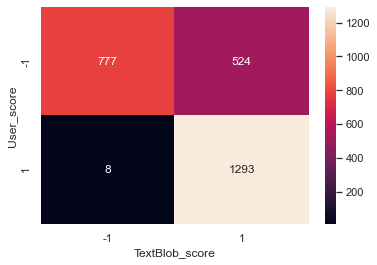

In [91]:
confusion_matrix = pd.crosstab(df['Score'], df['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

Noting that the -1 is actually the positive class in this case (i.e. the class we are interested in representing negative reviews) and the +1 is actually the negative class (the class representing good reviews that we are not interested in).

In [92]:
# Metrics function (pos_label = -1 as that represents negative reviews which is the class we are interested in
def metrics(y_true,y_pred):
    a = accuracy_score(y_true, y_pred)*100
    p = precision_score(y_true, y_pred,pos_label = -1)*100
    r = recall_score(y_true, y_pred,pos_label = -1)*100
    f1 = f1_score(y_true, y_pred,pos_label = -1)*100
    roc = roc_auc_score(y_true,y_pred)*100
    
    return a,p,r,f1,roc

In [93]:
metrics(df['Score'], df['TB_score'])

(79.55418908531898,
 98.98089171974522,
 59.72328977709454,
 74.49664429530202,
 79.55418908531897)

## VADER

A compound score greater than and equal to 0.05 is positive and negative is <= 0.05. Neutral is defined by VADER as between -0.05 and 0.05. 

In [101]:
# How many instances are affected by this (ie how many does VADER say are neutral)
df[(df["VComp"]>-0.05) & (df["VComp"]<0.05)].head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score
52,Arundel,Attractions,-1,Arundel Castle NOT dog friendly Arrived today...,0.104167,0.283333,0.047,0.904,0.049,0.0186,1
153,Bognor,Food,-1,Flies Went in for a sandwiches. Used toilet fi...,0.072222,0.111111,0.000,1.000,0.000,0.0000,1
221,Littlehampton,Food,1,Plants and food yippee Haskins garden centre h...,0.050000,0.625000,0.000,1.000,0.000,0.0000,1
391,Bognor,Food,-1,Boarded up - patio overgrown - Closed This pub...,0.059091,0.251136,0.000,1.000,0.000,0.0000,1
562,Arundel,Attractions,-1,"Wet, wetlands. Called in to view visitors cent...",-0.122222,0.188889,0.000,1.000,0.000,0.0000,-1


Most of these are actually scored as bad reviews by users so we will treat compound scores between -0.05 and +0.05 as negative. Therefore good reviews are compound score of 0.05 and above and bad reviews as compound score of less than 0.05.

In [102]:
# Set polarities greater than equal to 0.05 (majority class) and polarities less than 0.05 to 1 (minority class)
conditions = [(df["VComp"]>=0.05),
              df["VComp"]<0.05]
choices = [1,-1]
df["VComp_score"] = np.select(conditions,choices,default = 'null')
df["VComp_score"] = df["VComp_score"].astype('int32')

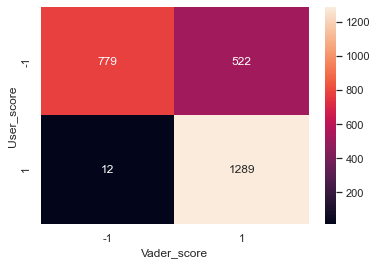

In [103]:
confusion_matrix = pd.crosstab(df['Score'], df['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [104]:
df["VComp_score"].value_counts()

 1    1811
-1     791
Name: VComp_score, dtype: int64

In [105]:
metrics(df['Score'], df['VComp_score'])

(79.47732513451191,
 98.48293299620732,
 59.87701767870869,
 74.47418738049714,
 79.47732513451191)

* Both analysers had very similar metrics with Vader achieving slightly better recall and F1 score
* Neither did as well with the bad reviews, misclassifying many of them as good reviews

## Examination of reviews which VADER got wrong

In [106]:
# Examine some reviews that VADER set as positive but user score was negative
wrong = df[df["Score"] != df["VComp_score"]]
wrong_neg = wrong[wrong["VComp_score"] == 1]
wrong_neg.head(2)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
0,Arundel,Food,-1,Very disappointing Three of us ate on a quiet ...,0.042381,0.592222,0.102,0.765,0.133,0.6200,1,1
4,Littlehampton,Food,-1,"High priced low volume Beautiful setting, grea...",0.281677,0.601083,0.037,0.831,0.133,0.6167,1,1


In [116]:
wrong_neg.shape

(522, 12)

In [117]:
wrong_neg["all_text"].iloc[0]

"Very disappointing Three of us ate on a quiet night. First of all the good bit. The beer is good.\n\nThe rest however was very disappointing. The waitress was so cold that we wondered if one of us had met her before and upset her in some way.\n\nThe food was a great disappointment. My son had the half pounder burger which tasted awful. Very salty and like some cheap mass produced rubbish. No texture, no taste. I have never seen him leave a burger before. Whitebait to start. Tiny portion but OK. My main was scampi. OKish, but again a tiny portion. The chips were good.\n\nWe didn't bother with desert....we didn;t feel welcome and it we had enough poor food. We were home by 8.30pm.\n\nWe are locals and will not be using the Spur again."

In [118]:
wrong_neg["all_text"].iloc[1]

'High priced low volume Beautiful setting, great atmosphere but very high priced drinks for very little volume of alcohol. Almost £8 per glass which you would expect a decent amount for the money you spend. Too much ice!!'

In [119]:
# Examine some reviews that VADER set as negative but user score was positive
wrong_pos = wrong[wrong["VComp_score"] == -1]
wrong_pos.head(2)

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score
221,Littlehampton,Food,1,Plants and food yippee Haskins garden centre h...,0.050000,0.625000,0.000,1.000,0.0,0.0000,1,-1
247,Littlehampton,Food,1,Sunday lunch Had Sunday lunch in the garden. V...,0.033333,0.454167,0.046,0.954,0.0,-0.0909,1,-1


In [120]:
wrong_pos.shape

(12, 12)

In [121]:
wrong_pos["all_text"].iloc[0]

'Plants and food yippee Haskins garden centre has a wide selection of plants and shrubs, if you can’t get it here then it’s very possible you won’t find it around. Also they do a wide range of meals, light snacks and coffee/tea. '

In [122]:
wrong_pos["all_text"].iloc[1]

'Sunday lunch Had Sunday lunch in the garden. Very tasty. Only slight downside was the flatness of the soft drinks, not just this visit but the week before too'

* Vader misclassified more negative reviews as positive than the reverse
* Looking at examples, these appear to be quite long and/or contain mixed sentiments

# Section 5: Relationship VADER polarity and length of review

Does the length of review affect the polarity that VADER gives?

## VADER classed as positive when the user score is negative

In [130]:
# Looking at reviews VADER misclassified as positive when they are scored negative by the user
wrong_neg["Num_tokens"] = wrong_neg["all_text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [131]:
wrong_neg.head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
0,Arundel,Food,-1,Very disappointing Three of us ate on a quiet ...,0.042381,0.592222,0.102,0.765,0.133,0.6200,1,1,162
4,Littlehampton,Food,-1,"High priced low volume Beautiful setting, grea...",0.281677,0.601083,0.037,0.831,0.133,0.6167,1,1,43
8,Littlehampton,Food,-1,Meal for 12 on 29th Dec 2019. Twelve of us vis...,0.063889,0.498611,0.024,0.875,0.101,0.8765,1,1,177
16,Littlehampton,Food,-1,Chips Been here before and last time said we w...,0.035516,0.403175,0.039,0.875,0.086,0.8588,1,1,165
19,Bognor,Accommodation,-1,Butlins discrimination Butlins discrimination....,0.127959,0.349740,0.030,0.923,0.046,0.1303,1,1,370


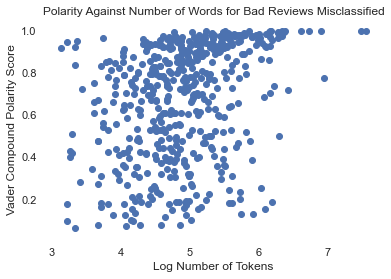

In [132]:
# Plot a scatter plot of the number of tokens and the vader compound polarity score - log used to spread data out
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_neg["Num_tokens"]), y = wrong_neg["VComp"])
plt.xlabel("Log Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Bad Reviews Misclassified")

In [134]:
# Correlation between the two series
pd.Series.corr(wrong_neg["Num_tokens"],wrong_neg["VComp"])

0.2876160268856325

Seems that the longer the review the more likely VADER is to class it as positive, thereby perhaps missing longer bad reviews

 ## VADER classed as negative when the user score is positive

In [136]:
# Looking at reviews VADER misclassified as negative when they are scored positive by the user
wrong_pos["Num_tokens"] = wrong_pos["all_text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [137]:
wrong_pos.head()

,Town,Category,Score,all_text,Polarity,Subjectivity,VNeg,VNeu,VPos,VComp,TB_score,VComp_score,Num_tokens
221,Littlehampton,Food,1,Plants and food yippee Haskins garden centre h...,0.050000,0.625000,0.000,1.000,0.000,0.0000,1,-1,52
247,Littlehampton,Food,1,Sunday lunch Had Sunday lunch in the garden. V...,0.033333,0.454167,0.046,0.954,0.000,-0.0909,1,-1,32
368,Bognor,Food,1,Give me that lemon and herb chicken recipe It'...,-0.200000,0.338889,0.082,0.866,0.052,-0.3753,-1,-1,54
419,Littlehampton,Food,1,Great breakfast good value Had breakfast as a ...,0.162135,0.480848,0.152,0.717,0.131,-0.6545,1,-1,139
1061,Bognor,Food,1,It really does not get better Returned for a f...,0.290000,0.540000,0.184,0.723,0.092,-0.3999,1,-1,36


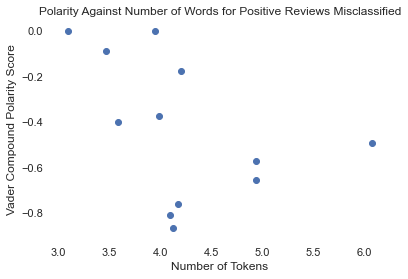

In [138]:
fig, ax = plt.subplots()
ax.set_facecolor("White")
plt.scatter(x = np.log(wrong_pos["Num_tokens"]), y = wrong_pos["VComp"])
plt.xlabel("Number of Tokens")
plt.ylabel("Vader Compound Polarity Score")
ax = plt.title("Polarity Against Number of Words for Positive Reviews Misclassified")

In [139]:
pd.Series.corr(wrong_neg["Num_tokens"], wrong_neg["VComp"])

0.2876160268856325

There are not many points in the scatter plot but there may be a negative correlation between the number of tokens and the Vader score - more likely to give negative score with shorter reviews?

# Section 6: Run VADER with cleaned reviews

In [166]:
df_clean = pd.read_csv("cleanedsampletext.csv",index_col = 0)
df_clean.head(2)

,OrgInd,Town,Category,Score,Review,Review_clean,Pos
0,0,Arundel,Food,1,Very disappointing Three of us ate on a quiet ...,disappointing three u ate quiet night first go...,"[('disappointing', 'JJ'), ('three', 'CD'), ('u..."
1,1,Bognor,Accommodation,0,Amazing place!!! We had a lovely stay at the ...,amazing place lovely stay inklenook room world...,"[('amazing', 'JJ'), ('place', 'NN'), ('lovely'..."


In [178]:
# Put bad reviews as -1 and good reviews as 1
df_clean.Score.replace(1, -1, inplace = True)
df_clean.Score.replace(0, 1, inplace = True)

In [167]:
df_clean = df_clean[["Town","Category","Review_clean","Score"]]

In [168]:
# Run TextBlob against each review in the dataframe
df_clean["Polarity"] = df_clean["Review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean["Subjectivity"] = df_clean["Review_clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [169]:
# Run VADER against each review in the dataframe
df_clean["VNeg"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['neg'])
df_clean["VNeu"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['neu'])
df_clean["VPos"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['pos'])
df_clean["VComp"] = df_clean["Review_clean"].apply(lambda x: sia.polarity_scores(x)['compound'])

In [170]:
# Set polarities TextBlob
conditions = [(df_clean["Polarity"]>0),df_clean["Polarity"]<=0]
choices = [1,-1]
df_clean["TB_score"] = np.select(conditions,choices,default = 'null')
df_clean["TB_score"] = df_clean["TB_score"].astype('int64')

In [171]:
# Set polarities VADER
conditions = [(df_clean["VComp"]>=0.05),df_clean["VComp"]<0.05]
choices = [1,-1]
df_clean["VComp_score"] = np.select(conditions,choices,default = 'null')
df_clean["VComp_score"] = df_clean["VComp_score"].astype('int32')

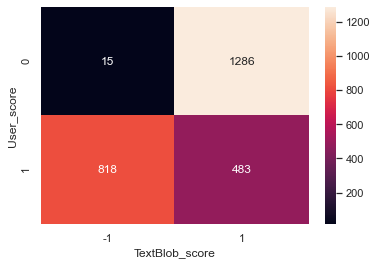

In [173]:
confusion_matrix = pd.crosstab(df_clean['Score'], df_clean['TB_score'], rownames=['User_score'], colnames=['TextBlob_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [179]:
df_clean["Score"].value_counts()

-1    1301
 1    1301
Name: Score, dtype: int64

In [180]:
metrics(df_clean['Score'], df_clean['TB_score'])

(80.86087624903921,
 98.19927971188476,
 62.874711760184475,
 76.6635426429241,
 80.86087624903921)

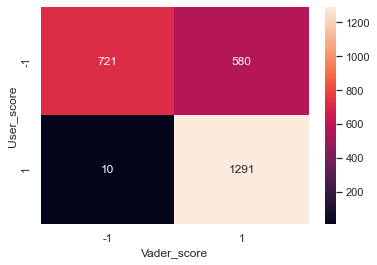

In [181]:
confusion_matrix = pd.crosstab(df_clean['Score'], df_clean['VComp_score'], rownames=['User_score'], colnames=['Vader_score'])
sns.heatmap(confusion_matrix, annot=True,fmt=".0f")
plt.show()

In [182]:
metrics(df_clean['Score'], df_clean['VComp_score'])

(77.32513451191392,
 98.63201094391245,
 55.41890853189854,
 70.96456692913385,
 77.32513451191392)

# Section 7: Summary

Summary

* There appears to be a negative relationship between the length of review and the VADER score.
* For negative reviews misclassified as positive, the longer reviews are more positive 
* There are very few good reviews misclassed as bad reviews.
* Therefore where people write long and negative reviews VADER does not always pick up the negative sentiment and tends to classify the review as positive
* When the data was cleaned, VADER's results generally got worse but TextBlob's improved 
* Recall on both is still fairly low, with the best recall of % on TextBlob with the cleaned text.

The Rules Based Sentiment Analysers achieve good accuracy but recall is poor. They appear to struggle with longer review text when classifying "Bad" reviews. They do not appear to account for context well in these cases. 